In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, roc_curve
from scipy.stats import skew, kurtosis
from scipy.fft import fft

from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras import regularizers
import re
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, LSTM, RepeatVector, BatchNormalization
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
from matplotlib import rc
from multiprocessing import cpu_count

In [166]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#93D30C", "#8F00FF", "#01BEFE", "#FFDD00","#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

tf.random.set_seed(42)
TIMESTEPS = 10 # the number of sample to be fed to the NN
FEATURES = 6
LABELS = 3
N_RECORDS = 11
BATCH_SIZE = 250     

In [167]:
df_train = pd.read_csv('dataset/train_motion_data.csv')
df_test = pd.read_csv('dataset/test_motion_data.csv')

### Preprocessing

In [168]:
len(df_train), len(df_test)

(3644, 3084)

In [169]:
# Merge class 'Slow' to 'Normal' class
df_train_2_cl = df_train.copy()
df_test_2_cl = df_test.copy()

two_class_mapping = {'SLOW': 'NORMAL'}
df_train_2_cl['Class'] = df_train_2_cl['Class'].replace(two_class_mapping)
df_test_2_cl['Class'] = df_test_2_cl['Class'].replace(two_class_mapping)

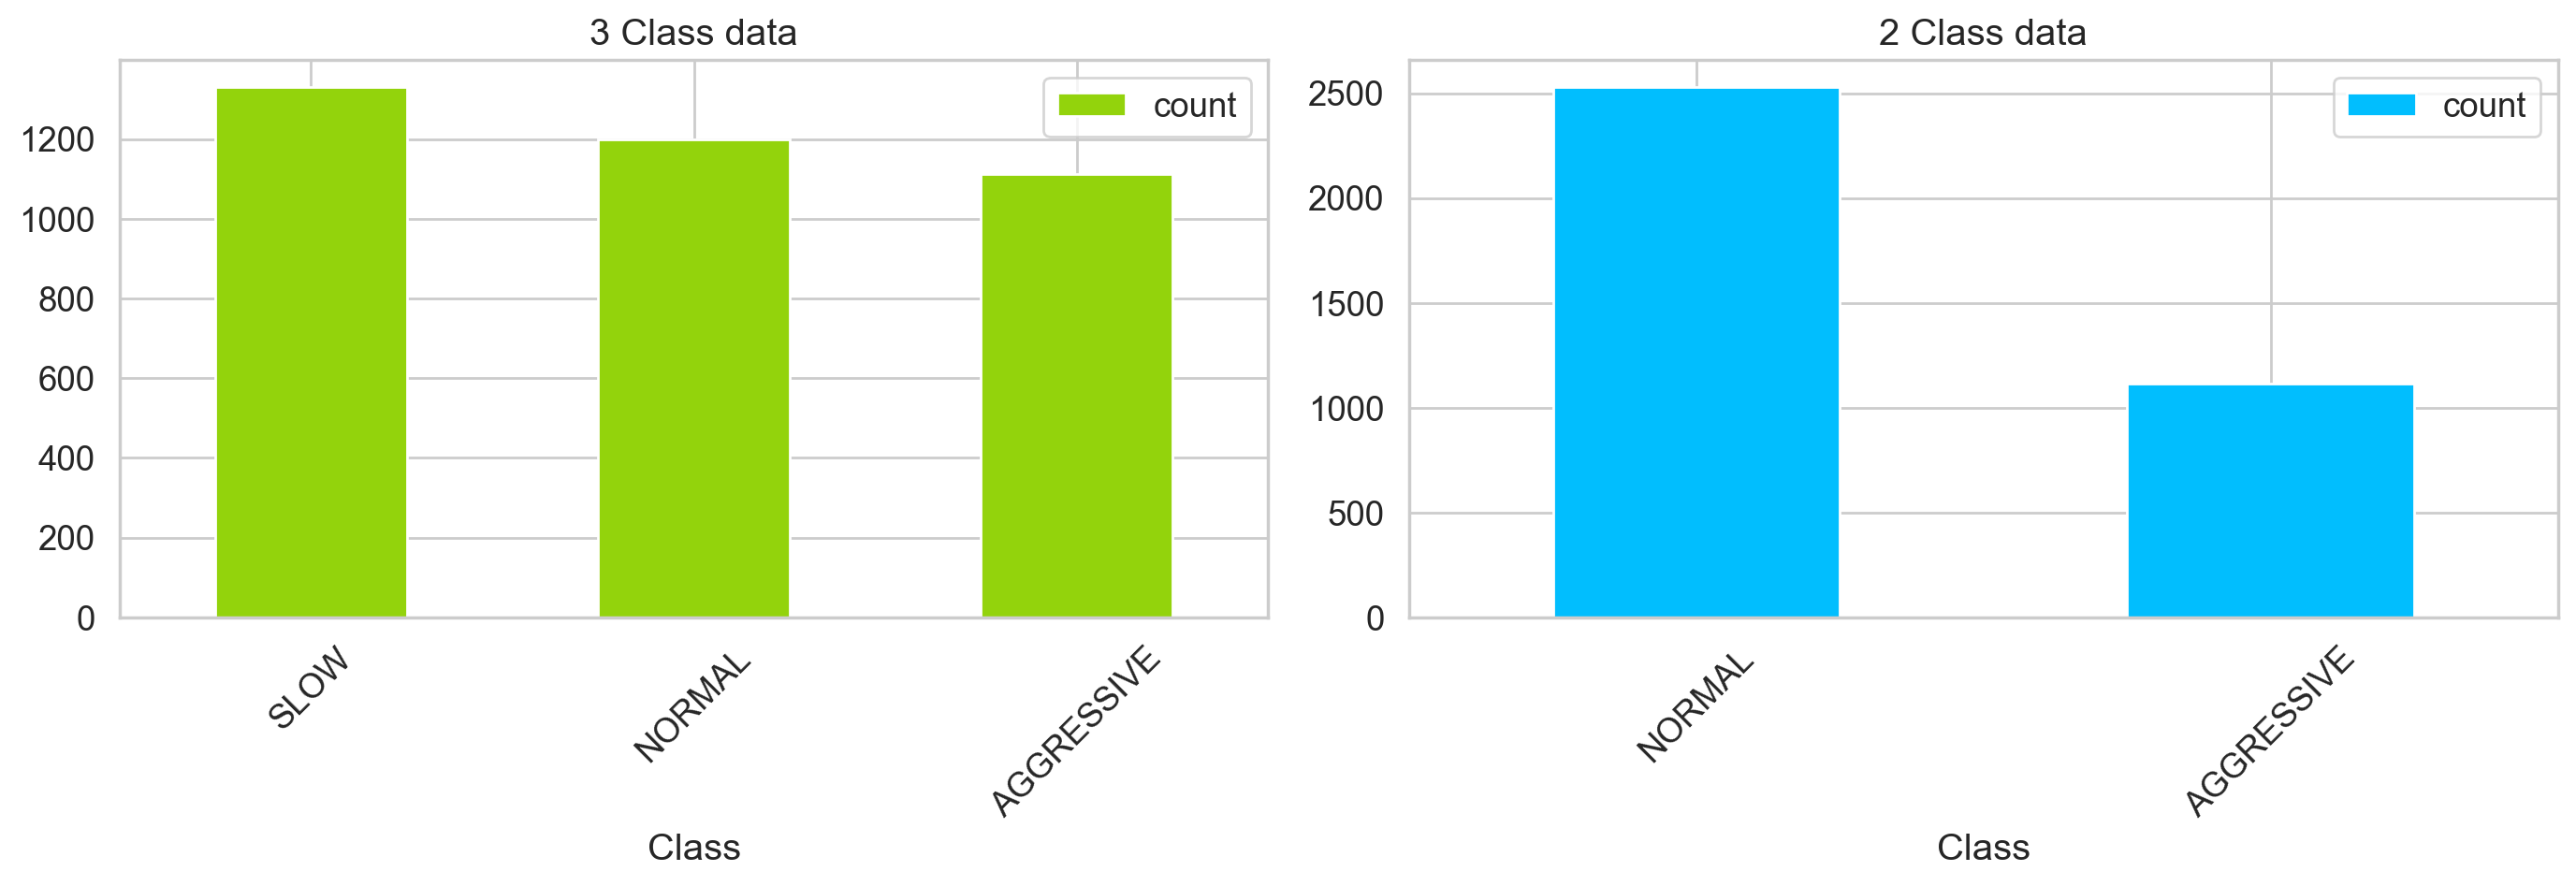

In [170]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
df_train.Class.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('3 Class data')
plt.legend()

plt.subplot(1, 2, 2)
df_train_2_cl.Class.value_counts().plot(kind='bar', color="#01BEFE")
plt.xticks(rotation=45)
plt.title('2 Class data')
plt.legend()

plt.tight_layout()
plt.show()

In [171]:

def extract_features(df, window_size):
    features = []
    labels = []
    for i in range(0, len(df), window_size):
        window = df.iloc[i:i+window_size]
        if len(window) == window_size:
            acc_x = window['AccX'].values
            acc_y = window['AccY'].values
            acc_z = window['AccZ'].values
            gyro_x = window['GyroX'].values
            gyro_y = window['GyroY'].values
            gyro_z = window['GyroZ'].values

            # Time domain features
            feature_vector = [
                np.mean(acc_x), np.std(acc_x), skew(acc_x), kurtosis(acc_x),
                np.mean(acc_y), np.std(acc_y), skew(acc_y), kurtosis(acc_y),
                np.mean(acc_z), np.std(acc_z), skew(acc_z), kurtosis(acc_z),
                np.mean(gyro_x), np.std(gyro_x), skew(gyro_x), kurtosis(gyro_x),
                np.mean(gyro_y), np.std(gyro_y), skew(gyro_y), kurtosis(gyro_y),
                np.mean(gyro_z), np.std(gyro_z), skew(gyro_z), kurtosis(gyro_z)
            ]

            # Frequency domain features (FFT)
            fft_acc_x = np.abs(fft(acc_x))
            fft_acc_y = np.abs(fft(acc_y))
            fft_acc_z = np.abs(fft(acc_z))
            fft_gyro_x = np.abs(fft(gyro_x))
            fft_gyro_y = np.abs(fft(gyro_y))
            fft_gyro_z = np.abs(fft(gyro_z))
            feature_vector.extend([
                np.mean(fft_acc_x), np.std(fft_acc_x),
                np.mean(fft_acc_y), np.std(fft_acc_y),
                np.mean(fft_acc_z), np.std(fft_acc_z),
                np.mean(fft_gyro_x), np.std(fft_gyro_x),
                np.mean(fft_gyro_y), np.std(fft_gyro_y),
                np.mean(fft_gyro_z), np.std(fft_gyro_z)
            ])
            
            features.append(feature_vector)
            labels.append(window['Class'].mode()[0])  # Assuming class labels are consistent within a window

    return np.array(features), np.array(labels)

#### Noise removing

In [172]:
df_train_normal = df_train.loc[df_train['Class'] == "NORMAL"]
df_train_slow = df_train.loc[df_train['Class'] == "SLOW"]
df_train_aggressive = df_train.loc[df_train['Class'] == "AGGRESSIVE"]

df_test_normal = df_test.loc[df_test['Class'] == "NORMAL"]
df_test_slow = df_train.loc[df_train['Class'] == "SLOW"]
df_test_aggressive = df_test.loc[df_test['Class'] == "AGGRESSIVE"]

Text(0, 0.5, 'Acceleration for normal class')

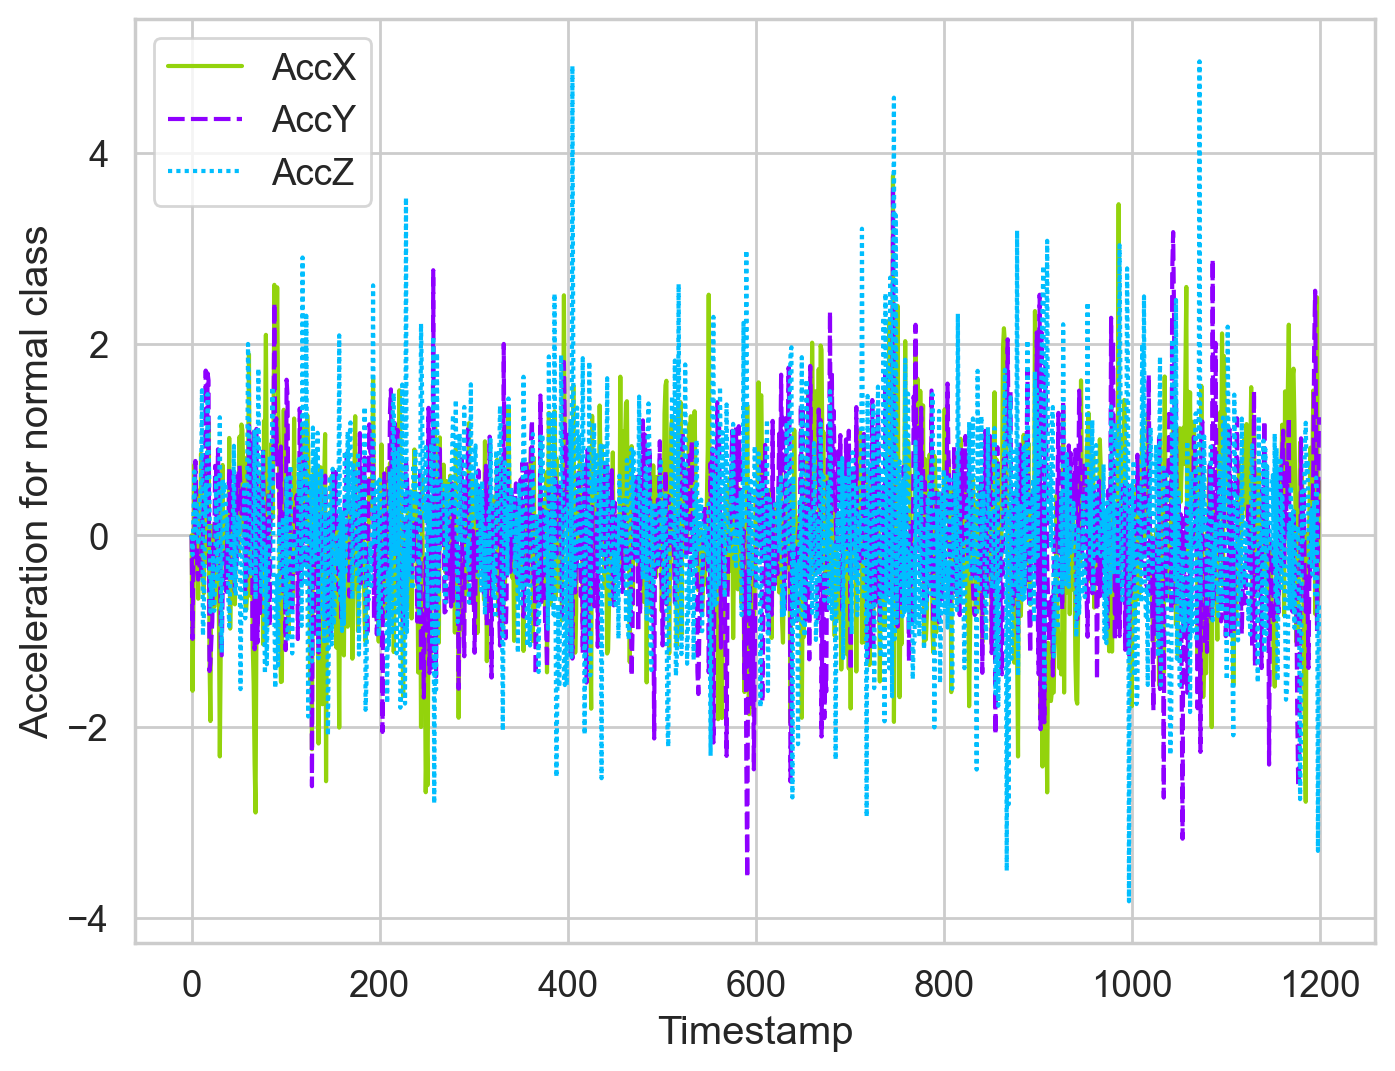

In [173]:
sns.lineplot(data=df_train_normal[['AccX', 'AccY', 'AccZ']])
plt.xlabel("Timestamp")
plt.ylabel("Acceleration for normal class")

Text(0, 0.5, 'Acceleration for slow class')

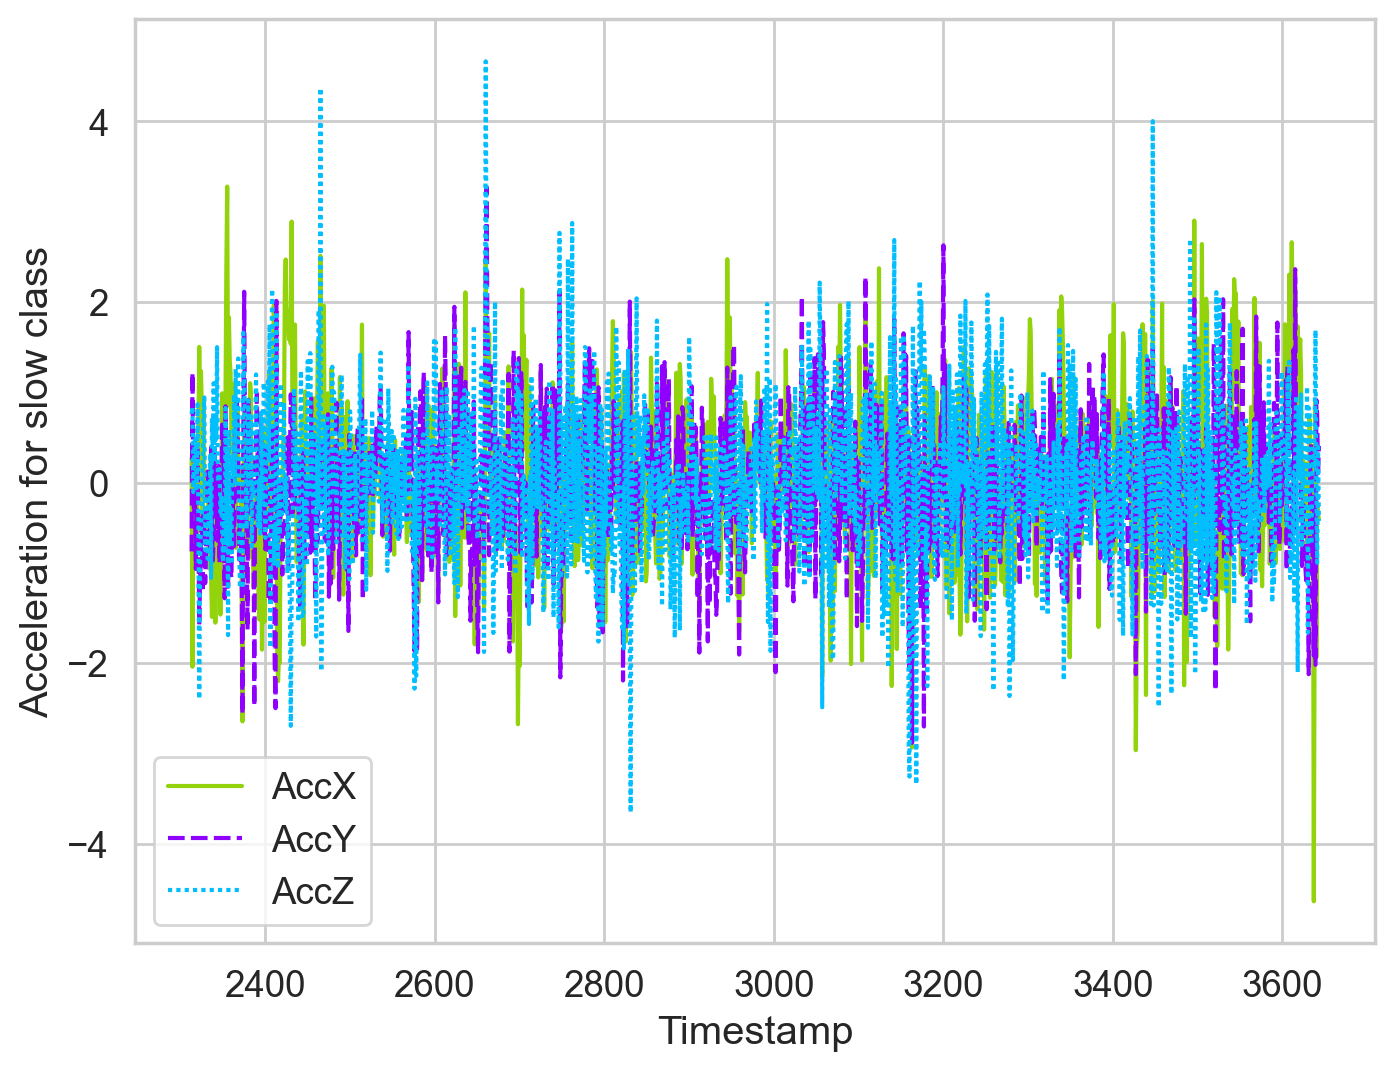

In [174]:
sns.lineplot(data=df_train_slow[['AccX', 'AccY', 'AccZ']])
plt.xlabel("Timestamp")
plt.ylabel("Acceleration for slow class")

Text(0, 0.5, 'Acceleration for aggressive class')

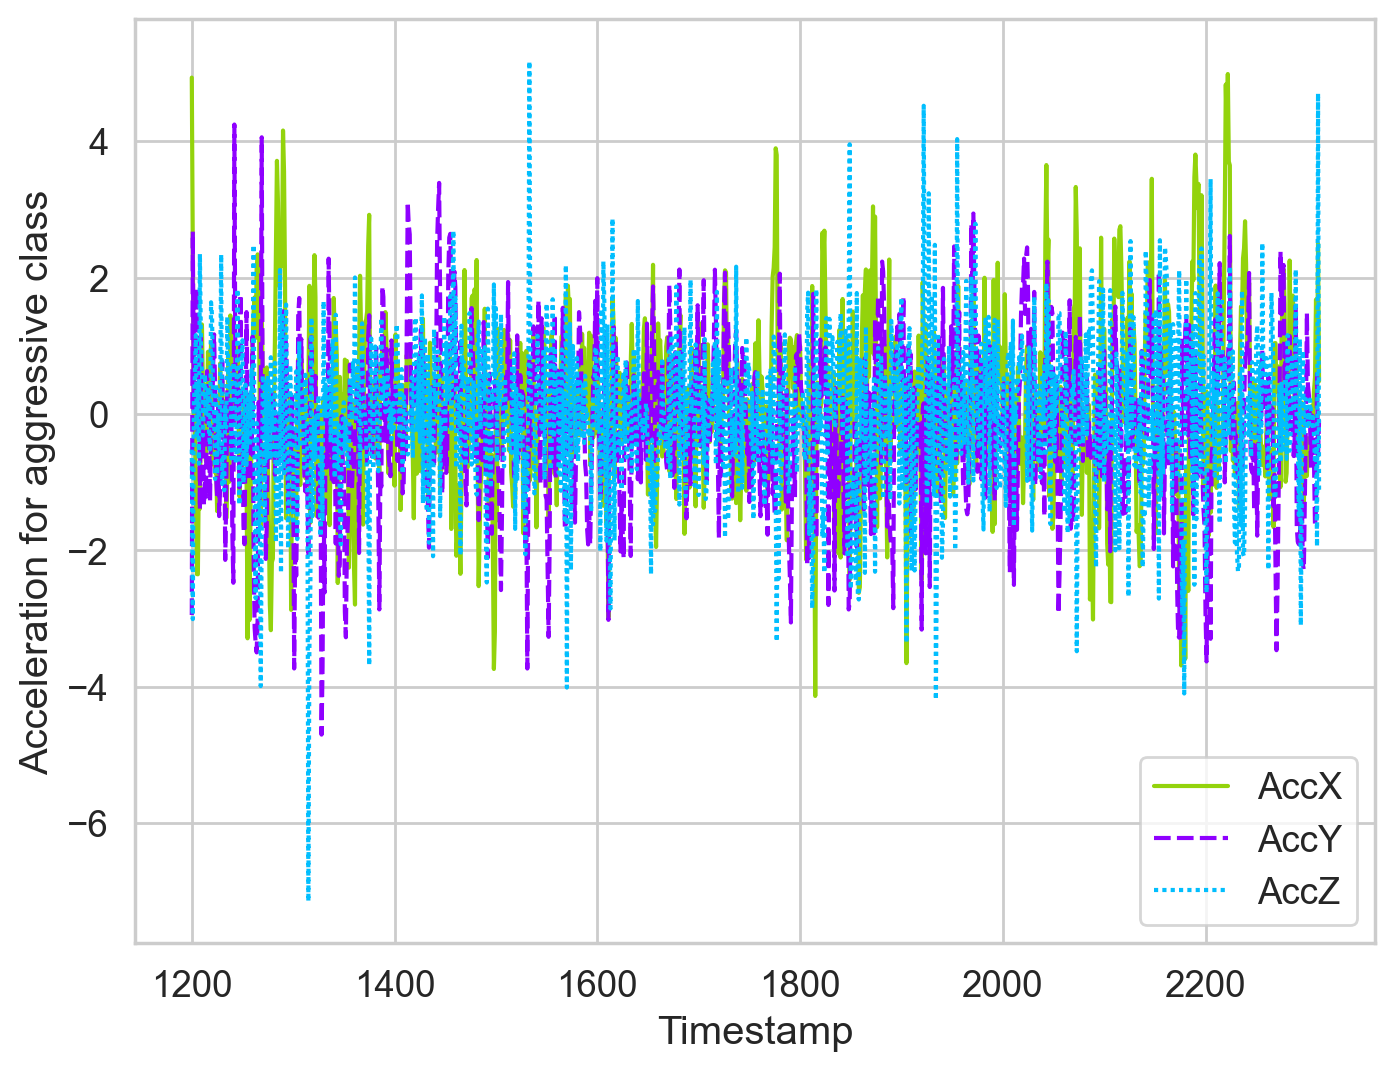

In [175]:
sns.lineplot(data=df_train_aggressive[['AccX', 'AccY', 'AccZ']])
plt.xlabel("Timestamp")
plt.ylabel("Acceleration for aggressive class")

In [176]:
df_train_normal = df_train_normal.iloc[N_RECORDS:]
df_train_normal = df_train_normal.iloc[:-N_RECORDS]

df_train_aggressive = df_train_aggressive.iloc[N_RECORDS:]
df_train_aggressive = df_train_aggressive.iloc[:-N_RECORDS]

df_train_slow = df_train_slow.iloc[N_RECORDS:]
df_train_slow = df_train_slow.iloc[:-N_RECORDS]

df_test_normal = df_test_normal.iloc[N_RECORDS:]
df_test_normal = df_test_normal.iloc[:-N_RECORDS]

df_test_aggressive = df_test_aggressive.iloc[N_RECORDS:]
df_test_aggressive = df_test_aggressive.iloc[:-N_RECORDS]

df_test_slow = df_test_slow.iloc[N_RECORDS:]
df_test_slow = df_test_slow.iloc[:-N_RECORDS]

df_train_slow = df_train_slow.tail(1260)
df_train_normal = df_train_normal.tail(1130)
df_train_aggressive = df_train_aggressive.tail(1040)

df_test_slow = df_test_slow.tail(1185)
df_test_normal = df_test_normal.tail(905)
df_test_aggressive = df_test_aggressive.tail(720)

In [177]:
# Features
X_train_normal = df_train_normal.iloc[: , :FEATURES]
X_train_slow = df_train_slow.iloc[: , :FEATURES]
X_train_aggressive = df_train_aggressive.iloc[: , :FEATURES]

X_test_normal = df_test_normal.iloc[: , :FEATURES]
X_test_slow = df_test_slow.iloc[: , :FEATURES]
X_test_aggressive = df_test_aggressive.iloc[: , :FEATURES]

# Labels
y_train_normal = df_train_normal.Class
y_train_slow = df_train_slow.Class
y_train_aggressive = df_train_aggressive.Class

y_test_normal = df_test_normal.Class
y_test_slow = df_test_slow.Class
y_test_aggressive = df_test_aggressive.Class


In [178]:
X_train = pd.concat([X_train_slow, X_train_normal, X_train_aggressive])
y_train = pd.concat([y_train_slow, y_train_normal, y_train_aggressive])

X_test = pd.concat([X_test_slow, X_test_normal, X_test_aggressive])
y_test = pd.concat([y_test_slow, y_test_normal, y_test_aggressive])

X_train.shape, y_train.shape

((3430, 6), (3430,))

In [179]:
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

In [180]:
y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)

In [181]:
y_train_percept = y_train.copy()
y_test_percept = y_test.copy()

In [182]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [183]:
X_train_percept = X_train.copy()
X_test_percept = X_test.copy()

In [184]:
train_samples = X_train.shape[0] // TIMESTEPS
X_train = X_train.reshape(train_samples, TIMESTEPS, FEATURES)

test_samples = X_test.shape[0] // TIMESTEPS
X_test = X_test.reshape(test_samples, TIMESTEPS, FEATURES)

print('Train features shape: ' + str(X_train.shape[0]))
print('Test features shape: ' + str(X_test.shape[0]))

Train features shape: 343
Test features shape: 281


In [185]:
y_train = y_train[::TIMESTEPS]
y_test = y_test[::TIMESTEPS]

print('Train labels shape: ' + str(y_train.shape[0]))
print('Test labels shape: ' + str(y_test.shape[0]))

Train labels shape: 343
Test labels shape: 281


### 2 Class Labelling

In [186]:
df_train_2_normal = df_train_2_cl.loc[df_train_2_cl['Class'] == "NORMAL"]
df_train_2_aggressive = df_train_2_cl.loc[df_train_2_cl['Class'] == "AGGRESSIVE"]

df_test_2_normal = df_test_2_cl.loc[df_test_2_cl['Class'] == "NORMAL"]
df_test_2_aggressive = df_test_2_cl.loc[df_test_2_cl['Class'] == "AGGRESSIVE"]

In [187]:
df_train_2_normal = df_train_2_normal.iloc[N_RECORDS:]
df_train_2_normal = df_train_2_normal.iloc[:-N_RECORDS]

df_train_2_aggressive = df_train_2_aggressive.iloc[N_RECORDS:]
df_train_2_aggressive = df_train_2_aggressive.iloc[:-N_RECORDS]

df_test_2_normal = df_test_2_normal.iloc[N_RECORDS:]
df_test_2_normal = df_test_2_normal.iloc[:-N_RECORDS]

df_test_2_aggressive = df_test_2_aggressive.iloc[N_RECORDS:]
df_test_2_aggressive = df_test_2_aggressive.iloc[:-N_RECORDS]

df_train_2_normal = df_train_2_normal.tail(2500)
df_train_2_aggressive = df_train_2_aggressive.tail(1090)

df_test_2_normal = df_test_2_normal.tail(2240)
df_test_2_aggressive = df_test_2_aggressive.tail(790)

df_train_2_normal.shape, df_train_2_aggressive.shape, df_test_2_normal.shape, df_test_2_aggressive.shape

((2500, 8), (1090, 8), (2240, 8), (790, 8))

In [188]:
# Features
X_train_2_normal = df_train_2_normal.iloc[: , :FEATURES]
X_train_2_aggressive = df_train_2_aggressive.iloc[: , :FEATURES]

X_test_2_normal = df_test_2_normal.iloc[: , :FEATURES]
X_test_2_aggressive = df_test_2_aggressive.iloc[: , :FEATURES]

# Labels
y_train_2_normal = df_train_2_normal.Class
y_train_2_aggressive = df_train_2_aggressive.Class

y_test_2_normal = df_test_2_normal.Class
y_test_2_aggressive = df_test_2_aggressive.Class

In [189]:
X_train_2 = pd.concat([X_train_2_normal, X_train_2_aggressive])
y_train_2 = pd.concat([y_train_2_normal, y_train_2_aggressive])

X_test_2 = pd.concat([X_test_2_normal, X_test_2_aggressive])
y_test_2 = pd.concat([y_test_2_normal, y_test_2_aggressive])

X_train_2.shape, y_train_2.shape

((3590, 6), (3590,))

In [190]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.fit_transform(X_test_2)

In [191]:
labelEncoder_2 = LabelEncoder()
y_train_2 = labelEncoder_2.fit_transform(y_train_2)
y_test_2 = labelEncoder_2.transform(y_test_2)

y_train_2 = to_categorical(y_train_2, num_classes=LABELS)
y_test_2 = to_categorical(y_test_2, num_classes=LABELS)

In [192]:
train_samples_two = X_train_2.shape[0] // TIMESTEPS
X_train_two = X_train_2.reshape(train_samples_two, TIMESTEPS, FEATURES)

test_samples_two = X_test_2.shape[0] // TIMESTEPS
X_test_two = X_test_2.reshape(test_samples_two, TIMESTEPS, FEATURES)

print('Train features shape: ' + str(X_train_two.shape[0]))
print('Test features shape: ' + str(X_test_two.shape[0]))

Train features shape: 359
Test features shape: 303


In [193]:
y_train_two = y_train_2[::TIMESTEPS]
y_test_two = y_test_2[::TIMESTEPS]

print('Train labels shape: ' + str(y_train_two.shape[0]))
print('Test labels shape: ' + str(y_test_two.shape[0]))

Train labels shape: 359
Test labels shape: 303


#### LSTM Model Building

In [194]:
def model_builder(hp):
    model = tf.keras.Sequential()

    # First LSTM layer with input shape and batch normalization
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=512, step=32), 
                   input_shape=(TIMESTEPS, FEATURES), return_sequences=True))
    model.add(BatchNormalization())

    # Additional LSTM layers with dropout and batch normalization
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(
            hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32),
            dropout=hp.Float(f'dropout_{i}_rate', min_value=0, max_value=0.5, step=0.1),
            return_sequences=True
        ))
        model.add(BatchNormalization())

    # Final LSTM layer without return_sequences
    model.add(LSTM(hp.Int('lstm_output_neurons', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(BatchNormalization())

    # Dropout for regularization
    model.add(Dropout(hp.Float('output_dropout_rate', min_value=0, max_value=0.5, step=0.1)))

    # Dense layer
    model.add(Dense(hp.Int('dense_neurons', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())

    # Output layer with softmax activation
    model.add(Dense(LABELS, activation='softmax'))

    # Learning rate selection
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    # Model compilation with additional metrics
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

#### Training model for 3 class

In [77]:
tuner_3 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='lstm_dir_3',
                     project_name='driving_behavior')

Reloading Tuner from lstm_dir_3/driving_behavior/tuner0.json


#### Training model for 2 class

In [78]:
tuner_2 = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='lstm_dir_2',
                     project_name='driving_behavior')

Reloading Tuner from lstm_dir_2/driving_behavior/tuner0.json


In [199]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [80]:
tuner_3.search(
        x=X_train,
        y=y_train,
        epochs=80,
        validation_data=(X_test, y_test),
        callbacks=[stop_early], 
        shuffle=True
)

In [81]:
tuner_2.search(
        x=X_train_two,
        y=y_train_two,
        epochs=80,
        validation_data=(X_test_two, y_test_two),
        callbacks=[stop_early], 
        shuffle=True
)

In [82]:
best_hyperparameters = tuner_2.get_best_hyperparameters()[0]
best_hyperparameters.values

{'input_unit': 32,
 'n_layers': 1,
 'lstm_0_units': 128,
 'dropout_0_rate': 0.4,
 'lstm_output_neurons': 160,
 'output_dropout_rate': 0.2,
 'dense_neurons': 320,
 'learning_rate': 0.01,
 'lstm_1_units': 256,
 'dropout_1_rate': 0.4,
 'lstm_2_units': 160,
 'dropout_2_rate': 0.4,
 'lstm_3_units': 256,
 'dropout_3_rate': 0.4,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0058'}

In [83]:
best_hps_3 = tuner_3.get_best_hyperparameters(num_trials=1)[0]
best_hps_2 = tuner_2.get_best_hyperparameters(num_trials=1)[0]

In [84]:
# Build the model with the optimal hyperparameters and train it on the data for 80 epochs
model_1 = tuner_3.hypermodel.build(best_hps_3)
history_3 = model_1.fit(X_train, y_train, epochs=80, validation_data=(X_test, y_test), 
    callbacks=[stop_early], shuffle=True)

model_2 = tuner_2.hypermodel.build(best_hps_2)
history_2 = model_2.fit(X_train_two, y_train_two, epochs=80, validation_data=(X_test_two, y_test_two), 
    callbacks=[stop_early], 
    shuffle=True)

val_acc_per_epoch_1 = history_3.history['val_accuracy']
best_epoch_1 = val_acc_per_epoch_1.index(max(val_acc_per_epoch_1)) + 1

val_acc_per_epoch_2 = history_2.history['val_accuracy']
best_epoch_2= val_acc_per_epoch_2.index(max(val_acc_per_epoch_2)) + 1
print(f'Best epoch for 3 class data: {best_epoch_1} \n Best epoch for 2 class data: {best_epoch_2}')

/Users/asus/Desktop/Comp702_Dissertation/driver_behaviour_dl_ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.3399 - loss: 1.5365 - precision: 0.3409 - recall: 0.2710 - val_accuracy: 0.4235 - val_loss: 1.0921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4337 - loss: 1.2475 - precision: 0.4543 - recall: 0.3203 - val_accuracy: 0.4235 - val_loss: 1.0944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.4712 - loss: 1.0868 - precision: 0.5218 - recall: 0.3853 - val_accuracy: 0.4235 - val_loss: 1.1021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.4989 - loss: 0.9843 - precision: 0.6037 - recall: 0.3747 - val_accuracy: 0.4235 - val_loss: 1.1102 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/80
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6363 - loss: 0.8465 - precision: 0.7100 - recall: 0.4641 - val_ac

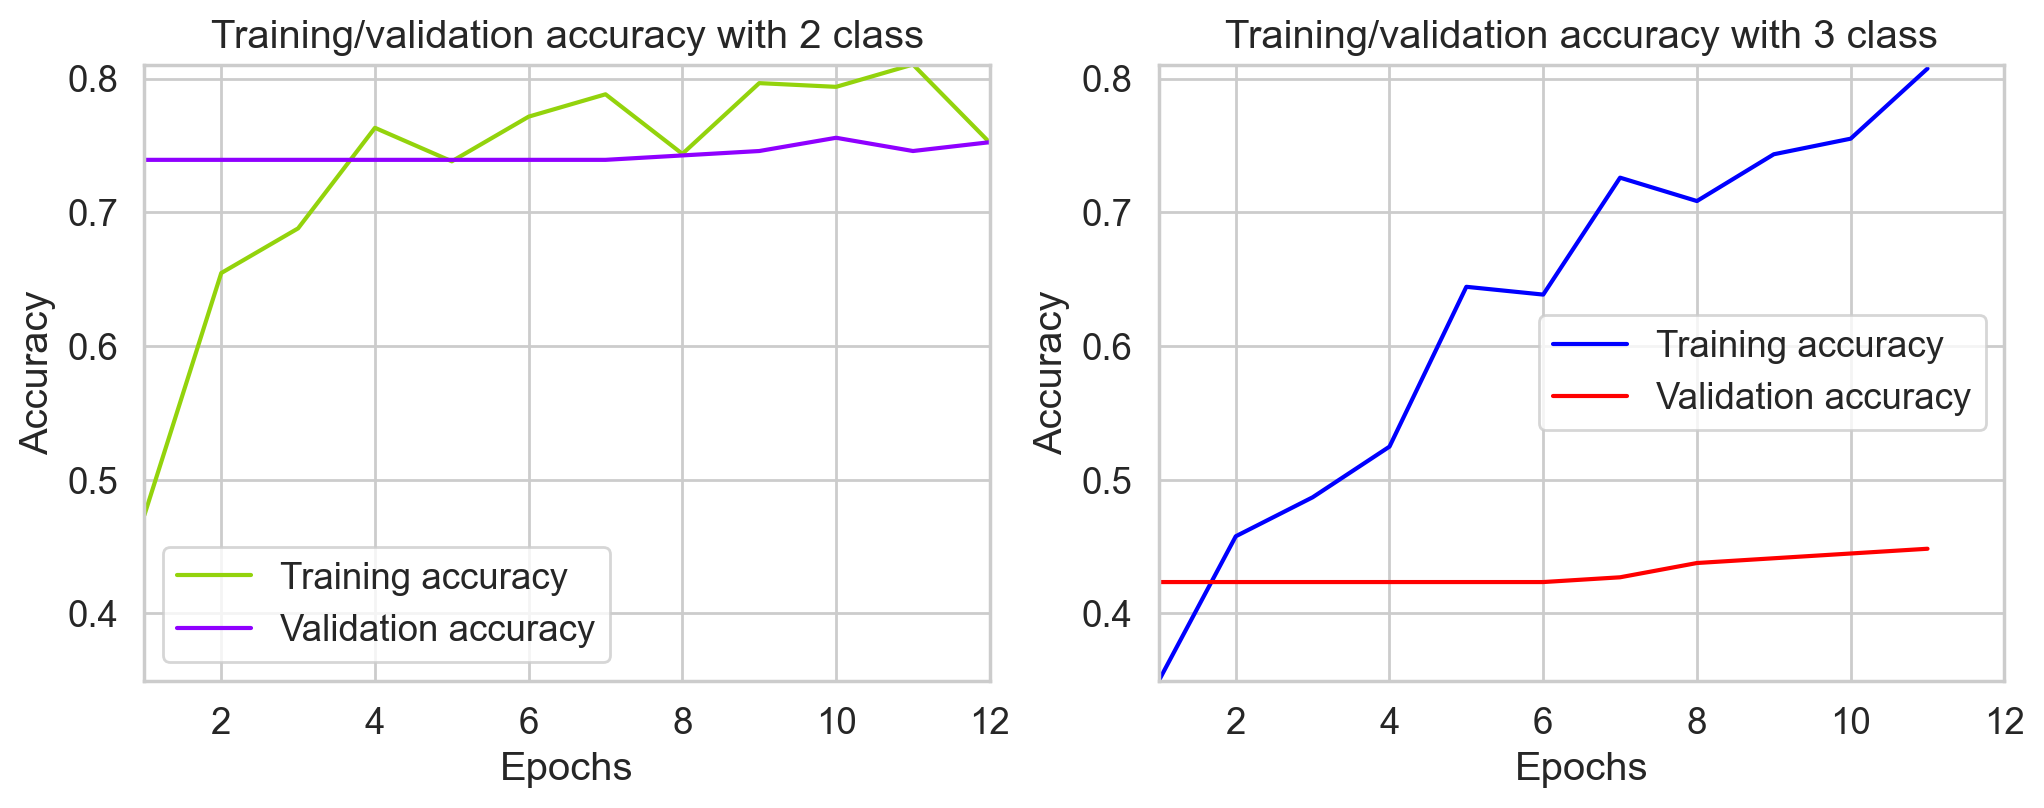

In [85]:
# Extract the accuracy values from the history
training_accuracy = history_2.history['accuracy']
validation_accuracy = history_2.history['val_accuracy']
epochs = range(1, len(training_accuracy) + 1)

training_accuracy_2 = history_3.history['accuracy']
validation_accuracy_2 = history_3.history['val_accuracy']
epochs_2 = range(1, len(training_accuracy_2) + 1)

# # Plot the accuracy values
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(epochs, training_accuracy, label='Training accuracy')
# plt.plot(epochs, validation_accuracy, label='Validation accuracy')
# plt.title('Training/validation accuracy with 2 class')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_2, training_accuracy_2, label='Training accuracy', color="blue")
# plt.plot(epochs_2, validation_accuracy_2, label='Validation accuracy', color="red")
# plt.title('Training/validation accuracy with 3 class')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

x_min = min(min(epochs), min(epochs_2))
x_max = max(max(epochs), max(epochs_2))
y_min = min(min(training_accuracy), min(validation_accuracy),
            min(training_accuracy_2), min(validation_accuracy_2))
y_max = max(max(training_accuracy), max(validation_accuracy),
            max(training_accuracy_2), max(validation_accuracy_2))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, validation_accuracy, label='Validation accuracy')
plt.title('Training/validation accuracy with 2 class')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(x_min, x_max)  # Set x-axis limit
plt.ylim(y_min, y_max)  # Set y-axis limit

plt.subplot(1, 2, 2)
plt.plot(epochs_2, training_accuracy_2, label='Training accuracy', color="blue")
plt.plot(epochs_2, validation_accuracy_2, label='Validation accuracy', color="red")
plt.title('Training/validation accuracy with 3 class')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xlim(x_min, x_max)  # Set x-axis limit
plt.ylim(y_min, y_max)  # Set y-axis limit

plt.show()

#### Training with defined the best hyperparameters (example: epoch)

In [86]:
hypermodel_1 = tuner_3.hypermodel.build(best_hps_3)
hypermodel_2 = tuner_2.hypermodel.build(best_hps_2)

# Retrain the model
hh_1 = hypermodel_1.fit(X_train, y_train, epochs=best_epoch_1, validation_data=(X_test, y_test), 
    callbacks=[stop_early])
hh_2 = hypermodel_2.fit(X_train_two, y_train_two, epochs=best_epoch_2, validation_data=(X_test_two, y_test_two), 
    callbacks=[stop_early])

Epoch 1/11
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.3410 - loss: 1.5560 - precision: 0.3344 - recall: 0.2634 - val_accuracy: 0.4235 - val_loss: 1.0834 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/11
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4138 - loss: 1.3882 - precision: 0.4463 - recall: 0.3506 - val_accuracy: 0.4235 - val_loss: 1.0778 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/11
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4862 - loss: 1.0778 - precision: 0.5220 - recall: 0.3850 - val_accuracy: 0.4235 - val_loss: 1.0754 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/11
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.5398 - loss: 0.9182 - precision: 0.6021 - recall: 0.3911 - val_accuracy: 0.4235 - val_loss: 1.0768 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/11
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.5715 - loss: 0.8630 - precision: 0.6423 - recall: 0.4336 - val_ac

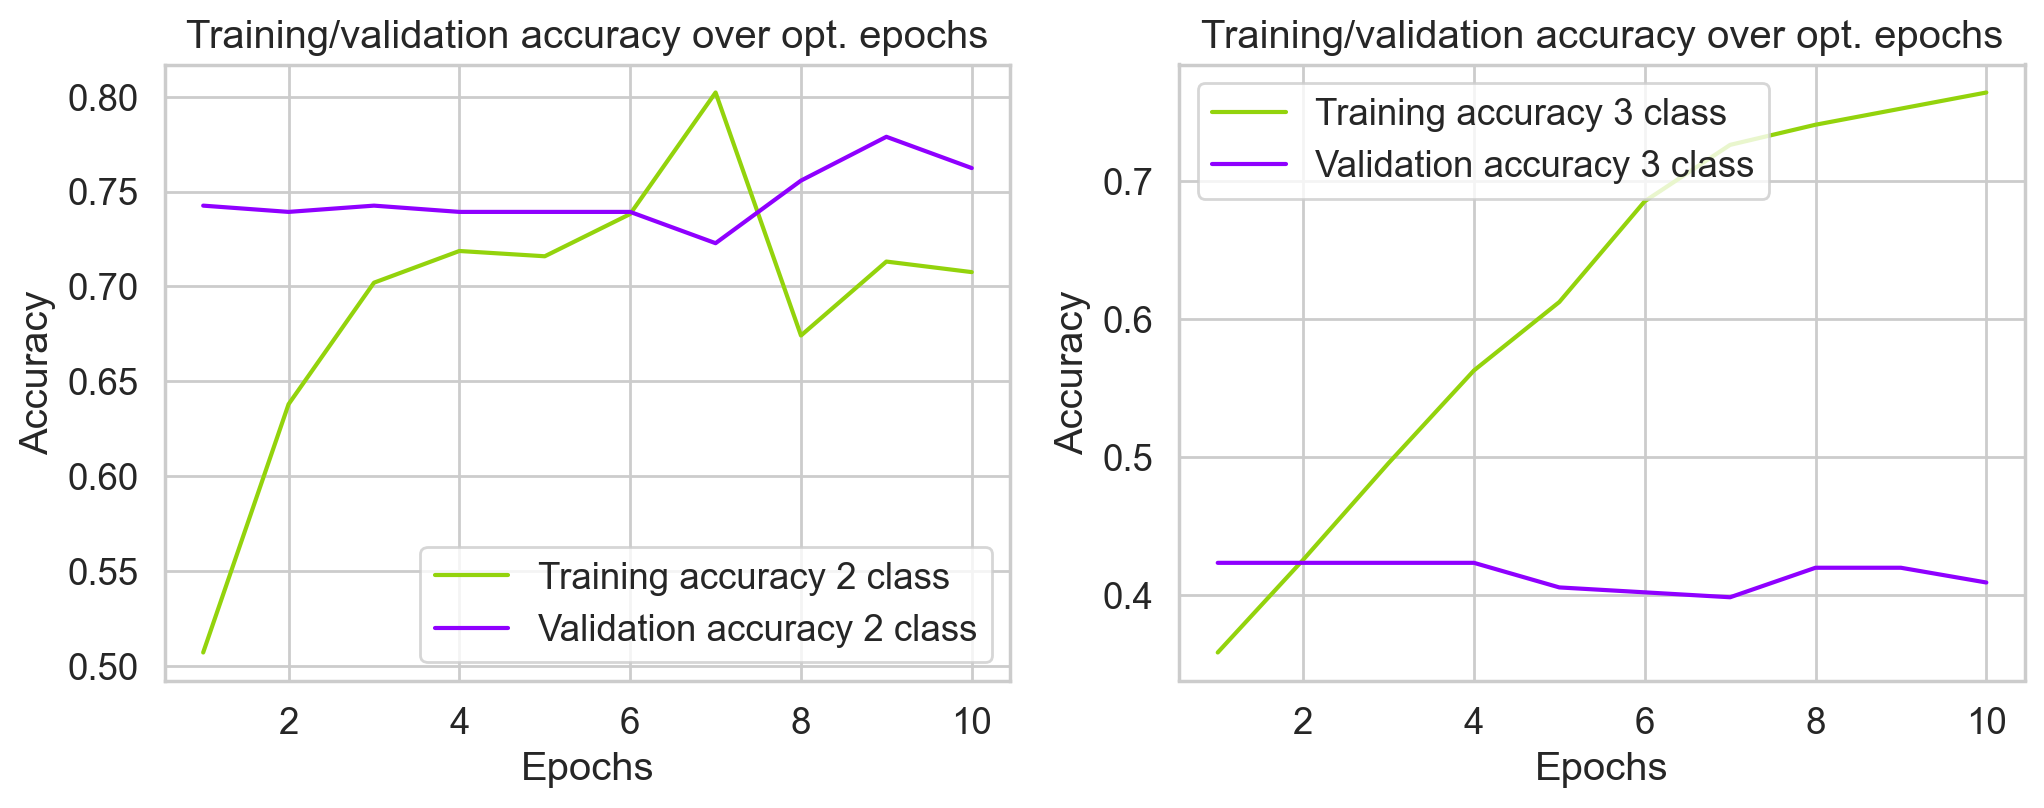

In [87]:
# Extract the accuracy values from the history
training_accuracy_t = hh_1.history['accuracy']
validation_accuracy_t = hh_1.history['val_accuracy']
epochs_t = range(1, len(training_accuracy_t) + 1)

training_accuracy_s = hh_2.history['accuracy']
validation_accuracy_s = hh_2.history['val_accuracy']
epochs_s = range(1, len(training_accuracy_s) + 1)

# Plot the accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_s, training_accuracy_s, label='Training accuracy 2 class')
plt.plot(epochs_s, validation_accuracy_s, label='Validation accuracy 2 class')
plt.title('Training/validation accuracy over opt. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_t, training_accuracy_t, label='Training accuracy 3 class')
plt.plot(epochs_t, validation_accuracy_t, label='Validation accuracy 3 class')
plt.title('Training/validation accuracy over opt. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [88]:
eval_result = hypermodel_1.evaluate(X_test, y_test)
eval_result_2 = hypermodel_2.evaluate(X_test_two, y_test_two)

print(f"Test loss, Test accuracy (3 class): {eval_result} \n Test loss, Test accuracy (2 class): {eval_result_2}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6288 - loss: 0.8426 - precision: 0.6885 - recall: 0.4716
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9233 - loss: 0.3043 - precision: 0.9233 - recall: 0.9233 
Test loss, Test accuracy (3 class): [1.1388521194458008, 0.40925267338752747, 0.4438502788543701, 0.29537367820739746] 
 Test loss, Test accuracy (2 class): [0.6432066559791565, 0.7623762488365173, 0.7623762488365173, 0.7623762488365173]


In [89]:
best_model_1 = tuner_3.get_best_models()[0]
best_model_2 = tuner_2.get_best_models()[0]

/Users/asus/Desktop/Comp702_Dissertation/driver_behaviour_dl_ml/.venv/lib/python3.12/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/Users/asus/Desktop/Comp702_Dissertation/driver_behaviour_dl_ml/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/asus/Desktop/Comp702_Dissertation/driver_behaviour_dl_ml/.venv/lib/p

In [90]:
y_pred = best_model_1.predict(x=X_test)
y_pred_2_cl = best_model_2.predict(x=X_test_two)

df_predicted = pd.DataFrame(y_pred, columns=['Aggressive', 'Normal', 'Slow'])

df_predicted

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


,Aggressive,Normal,Slow
0,0.008213,0.798653,0.193135
1,0.061956,0.074713,0.863331
2,0.020450,0.062971,0.916579
3,0.085478,0.214890,0.699632
4,0.015257,0.626568,0.358175
...,...,...,...
276,0.115997,0.332070,0.551933
277,0.018269,0.185124,0.796607
278,0.022254,0.076502,0.901244
279,0.015726,0.775170,0.209104


In [91]:
class_labels = np.argmax(y_train, axis=1)

# Fit the LabelEncoder with the class labels
labelEncoder.fit(class_labels)

actual_y_test = np.argmax(y_test, axis=1)
actual = labelEncoder.inverse_transform(actual_y_test)

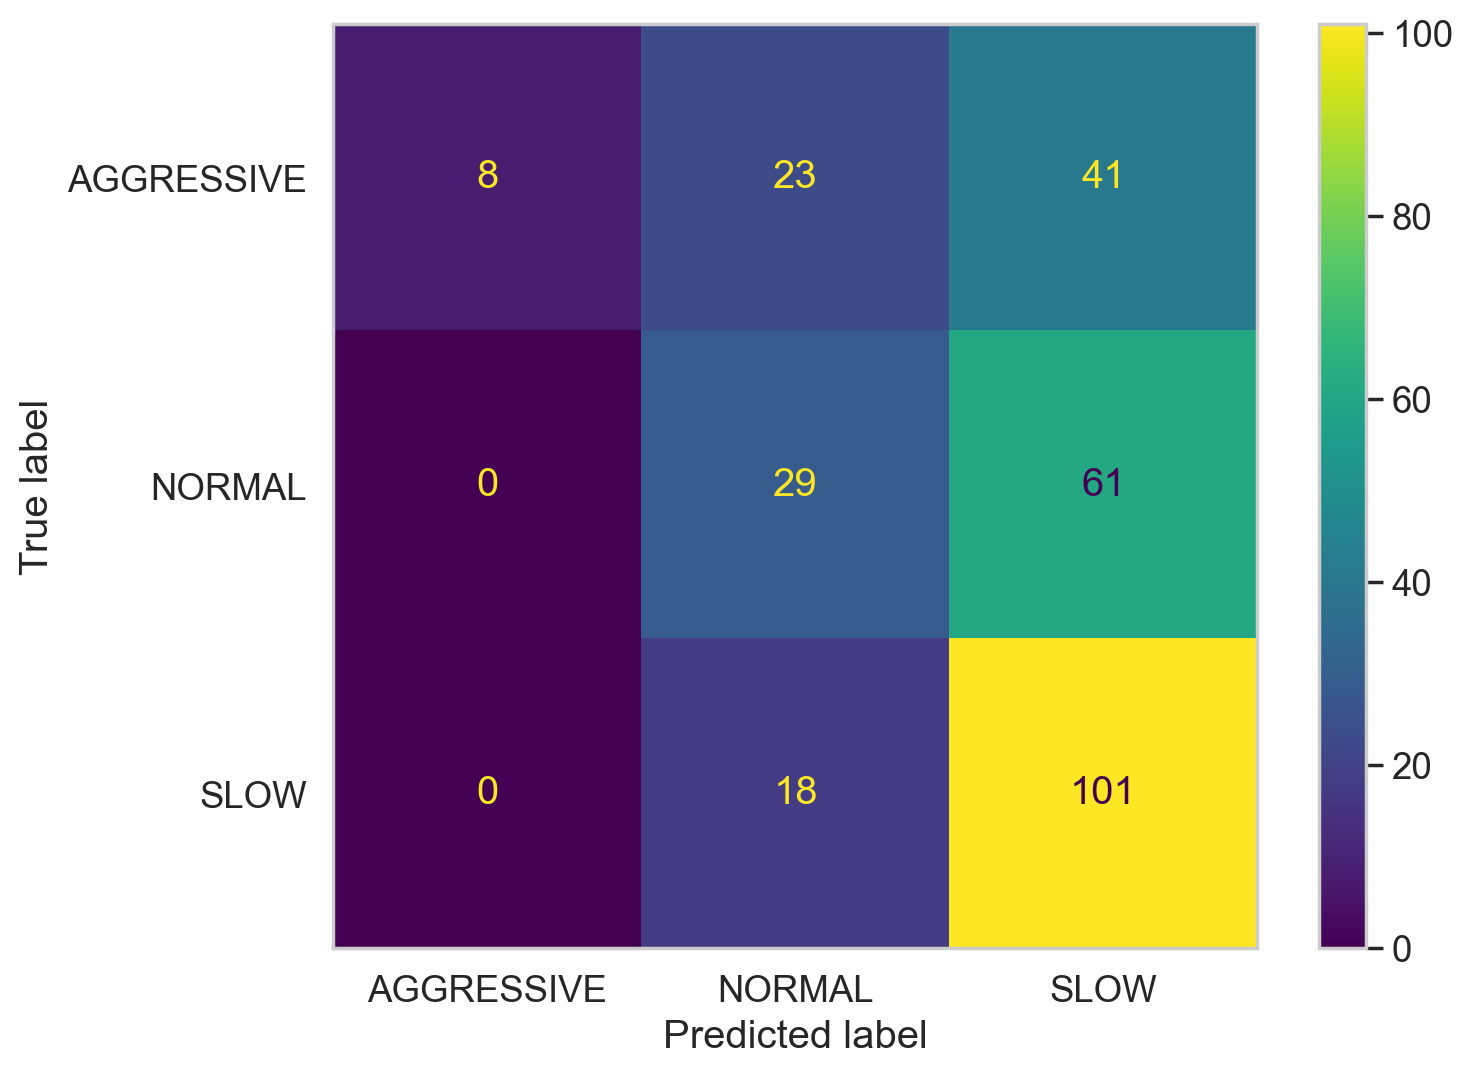

In [92]:
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(actual_y_test, y_pred)
classes = ['AGGRESSIVE', 'NORMAL', 'SLOW']
disp = ConfusionMatrixDisplay.from_predictions(actual_y_test, y_pred, display_labels=classes)

plt.rcParams['figure.figsize'] = [12, 6]
plt.grid(False)
plt.show()

## Multi Class classification with Deep Learning 

In [261]:
# Changing labels
class_mapping = {'NORMAL': 1, 'AGGRESSIVE': 2}
df_train_2_cl['Class'] = df_train_2_cl['Class'].replace(class_mapping)
df_test_2_cl['Class'] = df_test_2_cl['Class'].replace(class_mapping)

features_mlp = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']

X_train_mlp = df_train_2_cl[features_mlp]
X_test_mlp = df_test_2_cl[features_mlp]

y_train_mlp = df_train_2_cl['Class']
y_test_mlp = df_test_2_cl['Class']

In [262]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_test_mlp = scaler.fit_transform(X_test_mlp)

In [263]:
y_train_mlp_encoded = to_categorical(y_train_mlp)
y_test_mlp_encoded = to_categorical(y_test_mlp)
y_train_mlp_encoded.shape

(3644, 3)

In [285]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=FEATURES))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_mlp_encoded.shape[1], activation='softmax'))

model.compile(loss=binary_crossentropy, optimizer=Adam(), metrics=['accuracy'])

history = model.fit(X_train_mlp, y_train_mlp_encoded,
          batch_size=BATCH_SIZE,
          epochs=150,
          verbose=1,
          validation_data=(X_test_mlp, y_test_mlp_encoded), 
          callbacks=[stop_early])

loss, accuracy = model.evaluate(X_test_mlp, y_test_mlp_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6050 - loss: 0.6645 - val_accuracy: 0.7361 - val_loss: 0.5790
Epoch 2/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.5597 - val_accuracy: 0.7361 - val_loss: 0.4725
Epoch 3/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.4685 - val_accuracy: 0.7361 - val_loss: 0.4207
Epoch 4/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6998 - loss: 0.4282 - val_accuracy: 0.7506 - val_loss: 0.4073
Epoch 5/150
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7160 - loss: 0.4141 - val_accuracy: 0.7555 - val_loss: 0.4005
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step - accuracy: 0.4769 - loss: 0.4955
Loss: 0.40054041147232056, Accuracy: 0.7555122971534729


In [286]:
history_2 = model.fit(X_train_percept, y_train_percept,
          batch_size=BATCH_SIZE,
          epochs=150,
          verbose=1,
          validation_data=(X_test_percept, y_test_percept), 
          callbacks=[stop_early])

loss, accuracy = model.evaluate(X_test_percept, y_test_percept)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3232 - loss: 1.1634 - val_accuracy: 0.3075 - val_loss: 0.7195
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3312 - loss: 0.6977 - val_accuracy: 0.3039 - val_loss: 0.6474
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3268 - loss: 0.6447 - val_accuracy: 0.3142 - val_loss: 0.6442
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3546 - loss: 0.6384 - val_accuracy: 0.3335 - val_loss: 0.6375
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3825 - loss: 0.6330 - val_accuracy: 0.3495 - val_loss: 0.6344
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.2131 - loss: 0.6454
Loss: 0.6343562602996826, Accuracy: 0.3494662046432495


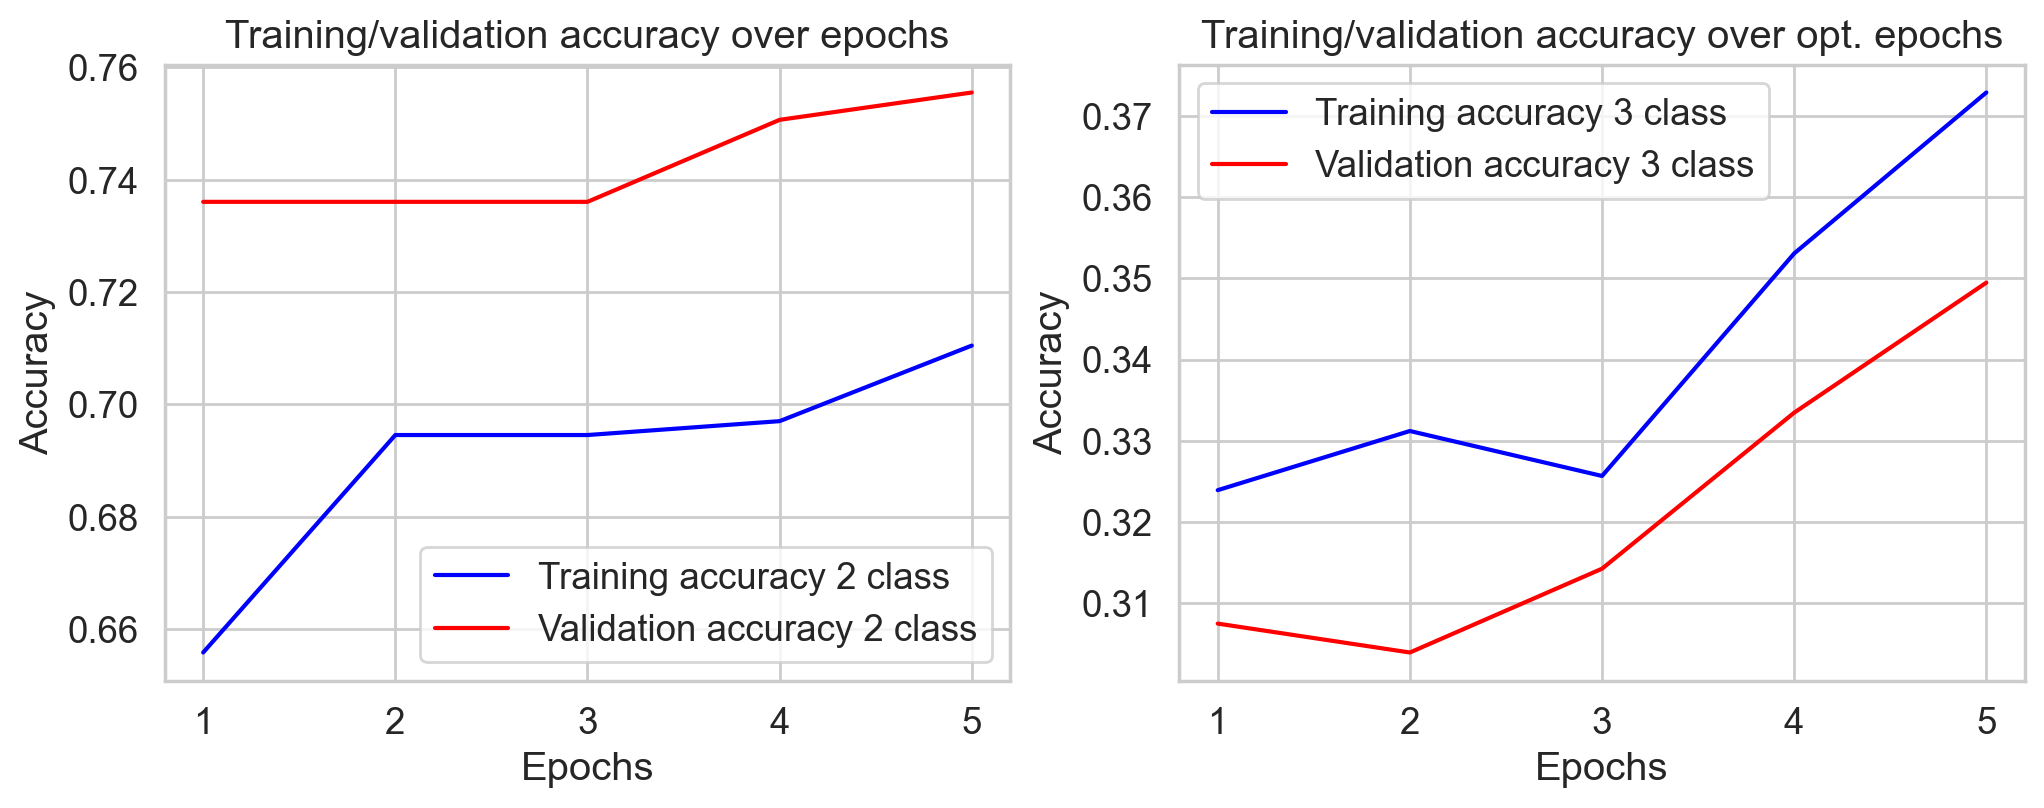

In [287]:
training_accuracy_nn = history.history['accuracy']
validation_accuracy_nn = history.history['val_accuracy']

training_accuracy_nn_3 = history_2.history['accuracy']
validation_accuracy_nn_3 = history_2.history['val_accuracy']

epochs_nn = range(1, len(training_accuracy_nn) + 1)
epochs_nn_3 = range(1, len(training_accuracy_nn_3) + 1)

# Plot the accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_nn, training_accuracy_nn, color='blue', label='Training accuracy 2 class')
plt.plot(epochs_nn, validation_accuracy_nn, color='red', label='Validation accuracy 2 class')
plt.title('Training/validation accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_nn_3, training_accuracy_nn_3, color='blue', label='Training accuracy 3 class')
plt.plot(epochs_nn_3, validation_accuracy_nn_3, color='red', label='Validation accuracy 3 class')
plt.title('Training/validation accuracy over opt. epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

## Random forest classification

In [ ]:
# Joining train and test together to get one, bad it was bad idea. Accuracy was only 38-42%

file_names = []
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

merged_data = pd.DataFrame()

for filename in reversed(file_names):
    df = pd.read_csv(filename, encoding='utf-8')
    merged_data = pd.concat([merged_data, df], ignore_index=True)

merged_data.to_csv('dataset/merged_data_pandas.csv', index=False)

In [29]:
df_merged = pd.read_csv('dataset/merged_data_pandas.csv')
df_merged = df_merged.drop(["Unnamed: 0"], axis=1)
df_merged = df_merged.sample(frac=1)
df_merged

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
4381,0.454370,0.417700,0.704473,0.016493,0.052763,-0.036805,AGGRESSIVE,819320.0
6512,2.196217,1.830174,-3.180645,-0.055589,-0.045586,0.036499,SLOW,820592.0
3804,0.048311,0.273388,-0.385564,0.023824,0.071700,0.086590,AGGRESSIVE,819008.0
1868,0.548459,0.313041,-0.827205,0.006261,0.042761,-0.080711,AGGRESSIVE,3582726.0
789,-1.228321,-0.920075,0.646091,-0.012675,0.006720,0.052458,NORMAL,3582055.0
...,...,...,...,...,...,...,...,...
1095,0.604494,-0.899347,-0.381105,-0.010843,-0.021991,-0.144241,NORMAL,3582220.0
4495,0.312500,-0.173881,-0.193680,0.042761,-0.009545,0.079871,NORMAL,819460.0
5305,0.541817,0.292654,0.205897,-0.034208,-0.147600,-0.000764,NORMAL,819897.0
2427,1.775776,-0.942046,-0.347246,0.056963,0.058643,-0.168675,SLOW,3583106.0


In [70]:
# Changing labels
class_mapping = {'NORMAL': 1, 'AGGRESSIVE': 2}
df_train_2_cl['Class'] = df_train_2_cl['Class'].replace(class_mapping)
df_test_2_cl['Class'] = df_test_2_cl['Class'].replace(class_mapping)

/var/folders/_c/7ngs318x1m36ms0yq0v2j5600000gn/T/ipykernel_87288/3432119599.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_2_cl['Class'] = df_train_2_cl['Class'].replace(class_mapping)
/var/folders/_c/7ngs318x1m36ms0yq0v2j5600000gn/T/ipykernel_87288/3432119599.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_2_cl['Class'] = df_test_2_cl['Class'].replace(class_mapping)


In [71]:
df_train_2_cl

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,1,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,1,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,1,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,1,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,1,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,1,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,1,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,1,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,1,3583791


In [72]:
df_train_2_cl = df_train_2_cl.dropna()

In [73]:
df_test_2_cl = df_test_2_cl.dropna()

In [141]:
window_size = 4 # check is diffetent windows

# Extract features and labels
X_train_rf, y_train_rf = extract_features(df_train_2_cl, window_size)
X_test_rf, y_test_rf = extract_features(df_test_2_cl, window_size)


In [142]:
# Splitting to training and testing
X_train_rf.shape, X_test_rf.shape

((911, 36), (771, 36))

In [143]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.fit_transform(X_test_rf)

In [144]:
rfc = RandomForestClassifier(n_estimators=300, random_state=42)

rf_history = rfc.fit(X_train_rf, y_train_rf)

y_pred_rf = rfc.predict(X_test_rf)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test_rf, y_pred_rf)))

Model accuracy score: 0.7769


In [145]:
y_test_rf

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [146]:
dt_train_accuracy_list = []
dt_test_accuracy_list = []
for depth in range(1,20):
    dtclf = RandomForestClassifier(max_depth=depth, n_estimators=300)
    dtclf.fit(X_train_rf, y_train_rf)
    y_pred_train = dtclf.predict(X_train_rf)
    dt_train_accuracy_list.append(accuracy_score(y_train_rf, y_pred_train))
    y_pred_test = dtclf.predict(X_test_rf)
    dt_test_accuracy_list.append(accuracy_score(y_pred_rf, y_pred_test))

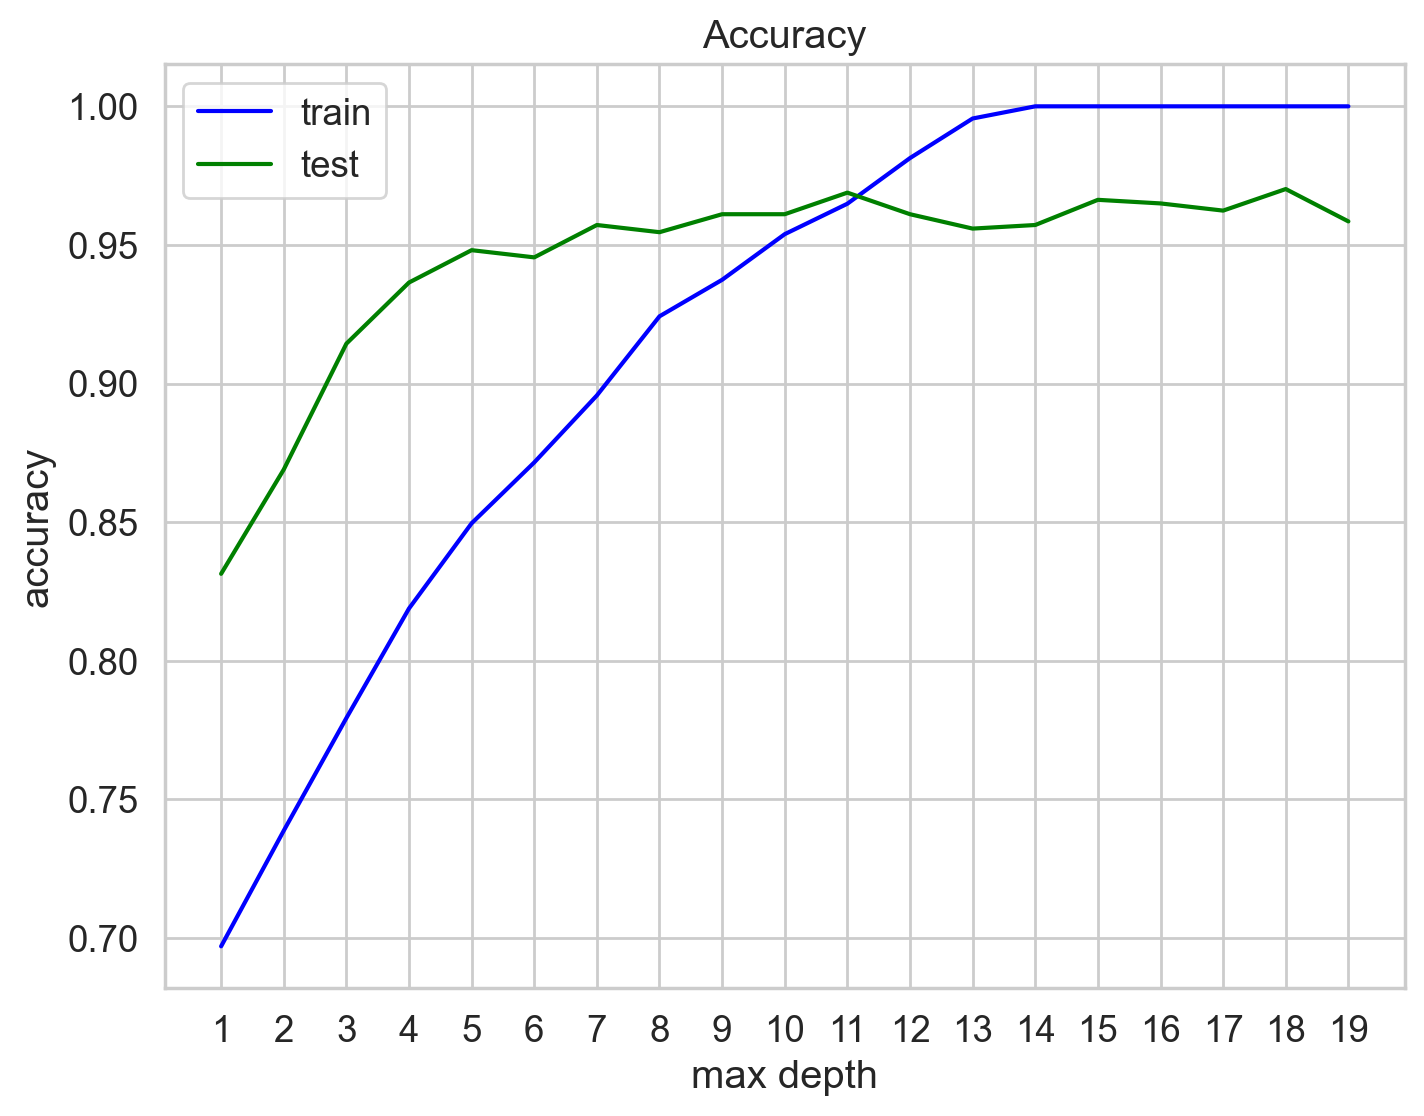

In [147]:
plt.plot(range(1,20), dt_train_accuracy_list, c='blue', label='train')
plt.plot(range(1,20), dt_test_accuracy_list, c='green', label='test')
plt.xticks(range(1,20))
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## KNN with sklearn

In [108]:
k_values = [i for i in range (1,31)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_rf, y_train_rf, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

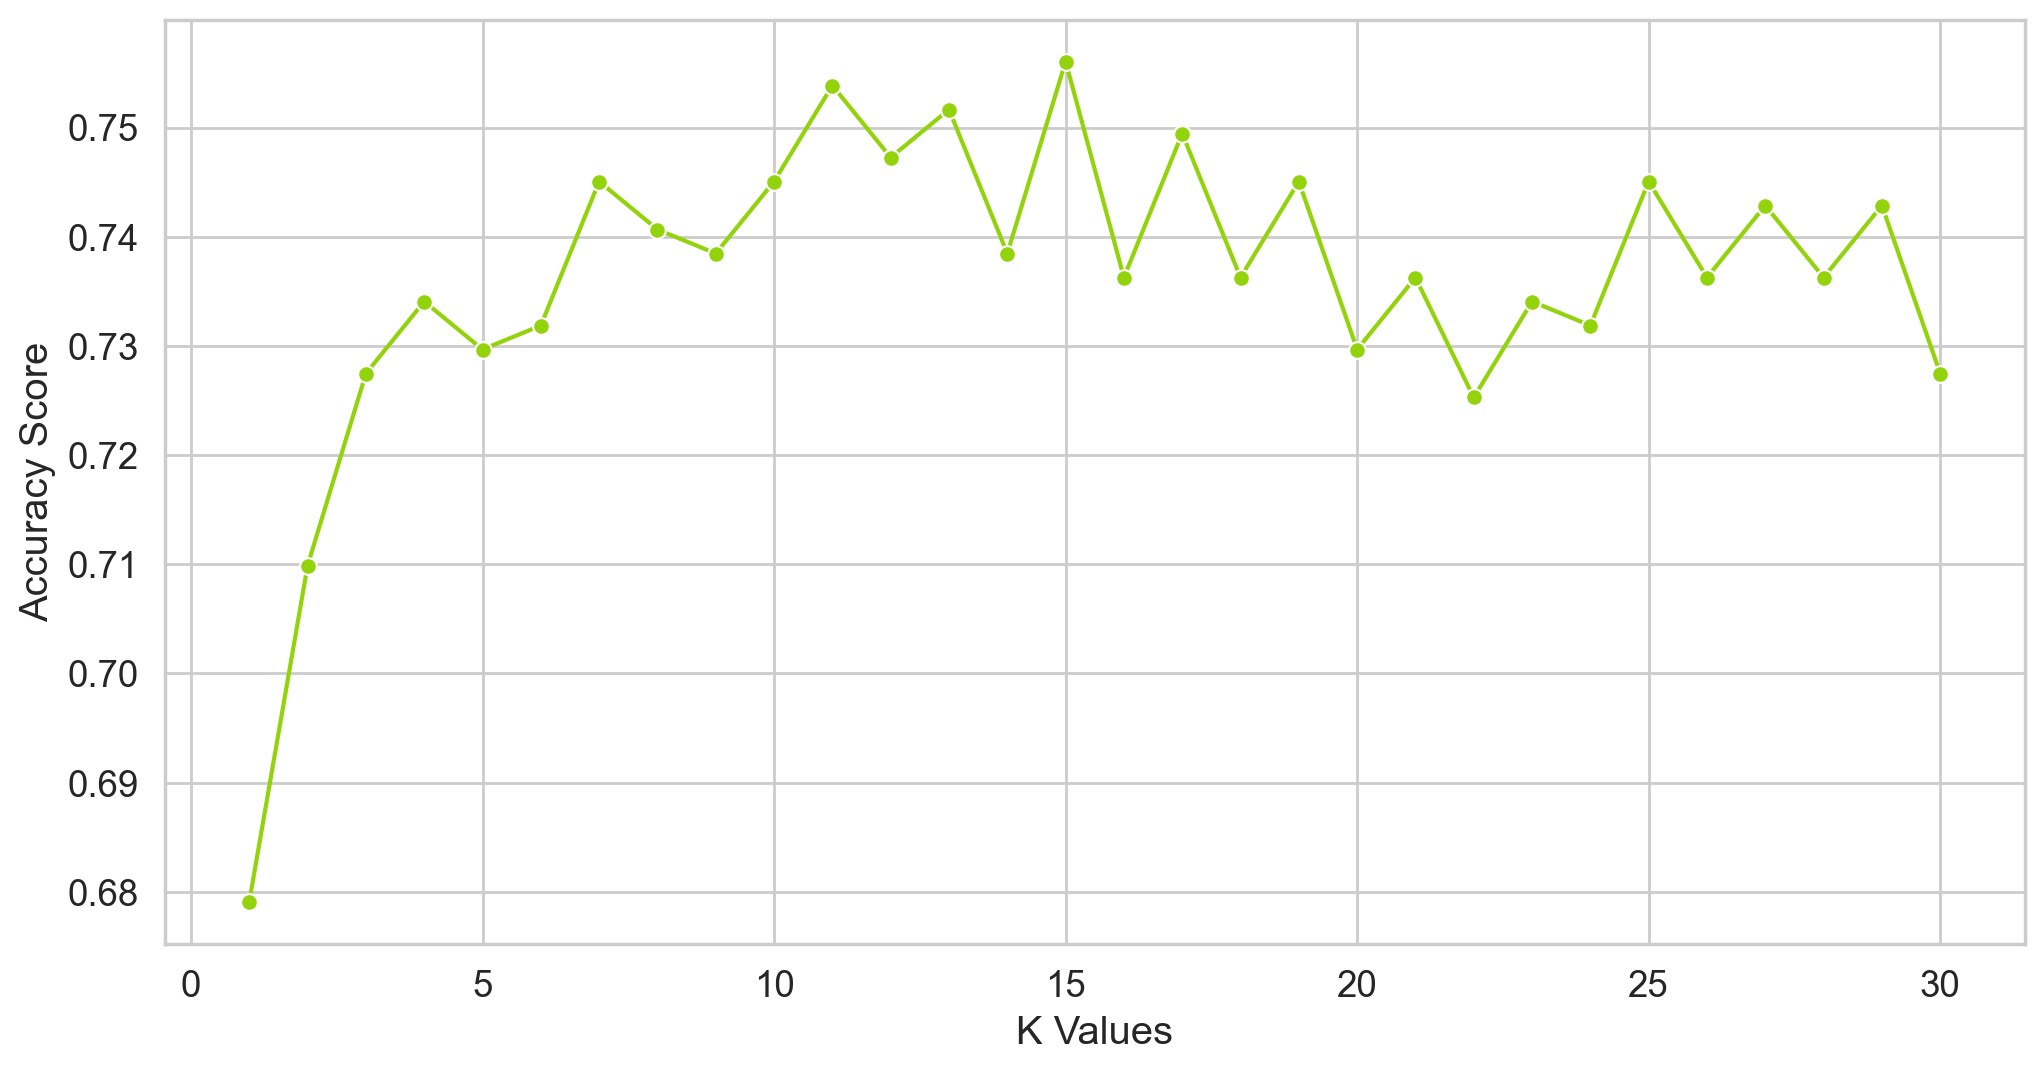

In [109]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")